# MNIST Classifier - Hello World of Deep Learnin (DL)! - Colab version
<hr/>

## Introduction

See the notebooks of the same directory for details.

This notebook is just an adaptation of the corresponding notebook to Google Colab.

__Key indicators for this Notebook__

- batch size = 64
- nb epochs = 10
- architecture =
   - 2 hidden conv2D layers of 32 and 64 units respectively,
   - 1 dropout of 50%
   - 1 output dense layer of 10 units with softmax activation function  
   - Trainable params = 34,826 (136.04 KB)
- Training average time = 63 seconds
- val accuracy = 99.11%

In [22]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print(f"[INFO] IN_COLAB = {IN_COLAB}.")

[INFO] IN_COLAB = True.


## Upload data from local filesystem to Colab

__Manual upload__

Use the left menu _Files > Upload >..._ or use the following code. The uploaded files will be available here: `/content/`.

__Upload with code__

In [23]:
# if IN_COLAB:
#    from google.colab import files
#    uploaded = files.upload()
#
#    for fn in uploaded.keys():
#      print('[INFO] User uploaded file "{name}" with length {length} bytes'.format(
#          name=fn, length=len(uploaded[fn])))

## Install (exotic) packages

In [24]:
if IN_COLAB:
    !pip install idx2numpy

## Imports

In [25]:
import os
import time
import idx2numpy
import numpy as np ; np.random.seed(42)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf ; tf.random.set_seed(42)

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from mpl_toolkits.axes_grid1 import ImageGrid

## Hardware

In [26]:
CPUS = tf.config.list_physical_devices('CPU')
GPUS = tf.config.list_physical_devices('GPU')

print("[INFO] Num CPUs:", len(CPUS), ", list = ", CPUS)
print("[INFO] Num GPUs:", len(GPUS), ", list = ", GPUS)

[INFO] Num CPUs: 1 , list =  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO] Num GPUs: 1 , list =  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Notebook parameters

In [27]:
# NumPy

np.set_printoptions(linewidth=200) # to enlarge the print() line
np.random.seed(42) # the random seed init
np.set_printoptions(precision=3) # for numpy floats: number of decimals

# TF: disable TF debug logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Globals & hyperparameters

In [28]:
# =============
# DATA_TOPDIR
# =============

# on COLAB
DATA_TOPDIR = "/content"

# =======
# MNIST
# =======

# dataset files
TRAIN_IMAGES_DATASET_FILE = os.path.join(DATA_TOPDIR, "train-images-idx3-ubyte")
assert os.path.exists(TRAIN_IMAGES_DATASET_FILE)

TRAIN_LABELS_DATASET_FILE = os.path.join(DATA_TOPDIR, "train-labels-idx1-ubyte")
assert os.path.exists(TRAIN_LABELS_DATASET_FILE)

TEST_IMAGES_DATASET_FILE = os.path.join(DATA_TOPDIR, "t10k-images-idx3-ubyte")
assert os.path.exists(TEST_IMAGES_DATASET_FILE)

TEST_LABELS_DATASET_FILE = os.path.join(DATA_TOPDIR, "t10k-labels-idx1-ubyte")
assert os.path.exists(TEST_LABELS_DATASET_FILE)

print(TRAIN_IMAGES_DATASET_FILE)
print(TRAIN_LABELS_DATASET_FILE)
print(TEST_IMAGES_DATASET_FILE)
print(TEST_LABELS_DATASET_FILE)

# The MNIST images format
num_pixels = 28 * 28

# the total number of digits
num_classes = 10

# ==========================
# Training hyperparameters
# ==========================

epochs = 10

batch_size = 64

# =======
# Demo
# =======

# Demo dir: where demonstration images are placed
DEMO_DIR = os.path.join(DATA_TOPDIR, "demo")
os.makedirs(DEMO_DIR, exist_ok=True)

# for demo images
nb_demo = 10
demo_prefix = "demo_img_"


/content/train-images-idx3-ubyte
/content/train-labels-idx1-ubyte
/content/t10k-images-idx3-ubyte
/content/t10k-labels-idx1-ubyte


## Data Preparation (Part I)

>__Note:__ In this notebook, all the steps regarding the understanding of the data are skipped. Indeed, in practice Data Scientist spend __80%__ of their time here!



In [29]:
# 1. Read each dataset into a conventional numpy 2D array
train_x_ndarray = idx2numpy.convert_from_file(TRAIN_IMAGES_DATASET_FILE)
train_y_ndarray = idx2numpy.convert_from_file(TRAIN_LABELS_DATASET_FILE)

test_x_ndarray = idx2numpy.convert_from_file(TEST_IMAGES_DATASET_FILE)
test_y_ndarray = idx2numpy.convert_from_file(TEST_LABELS_DATASET_FILE)

(60000, 28, 28) (60000,)
train_x_ndarray[0] = 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18

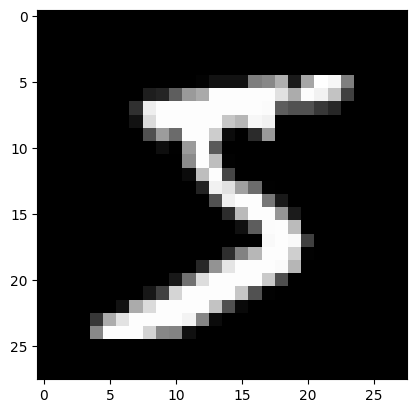

In [30]:
# quick check
print(train_x_ndarray.shape, train_y_ndarray.shape) # => (60000, 28, 28) (60000,)
print(f"train_x_ndarray[0] = \n{train_x_ndarray[0]}, \ntrain_y_ndarray[0] = {train_y_ndarray[0]}" )
print(train_x_ndarray[0].shape, train_y_ndarray[0].shape) # => (28, 28) ()
plt.imshow(train_x_ndarray[0], cmap='gray')

## Model construction & configuration

>__Note:__ In this notebook, all the steps regarding the (best) model selection and evaluation are skipped. We propose directly the best model architecture: a __Convolutional Neural Network (CNN)__

In [31]:
def build_model():
    model = Sequential()
    # =================================
    # Feature extractor
    # =================================
    model.add(Input(shape=(28,28,1))),
    model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2))),
    model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2))),
    # =================================
    # Neck
    # =================================
    model.add(Flatten()),
    model.add(Dropout(0.5))
    # =================================
    # Head
    # =================================
    model.add(Dense(units=num_classes, activation="softmax"))
    # =================================
    # Compile model
    # =================================
    model.compile(loss="categorical_crossentropy",
                  # optimizer="adam",
                  optimizer=tf.keras.optimizers.Adam(1e-3),
                  metrics=["accuracy"])
    return model

# Construct the model and show it
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          16,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

## Data Preparation (Part II)

>__Important:__  Since we know our target ML model now, we need to finalize the preparation of our data according this model (see the Input layer defined by `Input(shape=(28,28,1))`). We need to make sure the training data match this shape!

In [32]:
X_train = train_x_ndarray.astype('float32')
X_test = test_x_ndarray.astype('float32')

# make sure you are not introducing nan
X_train = np.nan_to_num(X_train, nan=0)
X_test = np.nan_to_num(X_test, nan=0)

# normalization: VERY IMPORTANT!!!!
X_train = X_train / 255
X_test = X_test / 255

# one hot encoding of labels
y_train = to_categorical(train_y_ndarray)
y_test = to_categorical(test_y_ndarray)
num_classes = y_train.shape[1]

# before reshaping
print("[INFO] before reshaping >>> ", X_train.shape, X_train[0].shape, y_train.shape, X_test.shape, y_train.shape)
print("[INFO] before reshaping >>> ",X_train[0], y_train[0])

[INFO] before reshaping >>>  (60000, 28, 28) (28, 28) (60000, 10) (10000, 28, 28) (60000, 10)
[INFO] before reshaping >>>  [[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.

In [33]:
# Explicit reshaping of training and testing data to (28, 28, 1)

# WARNING:
# Here, we could have rely on implicit broadcasting of TF Keras to not reshape and let ate of shape (28, 28) to be automatically
# reshaped into (28, 28, 1) ; bit it is a bad practice!

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print("[INFO] After reshaping >>> ", X_train.shape, X_train[0].shape, y_train.shape, X_test.shape, y_train.shape)

[INFO] After reshaping >>>  (60000, 28, 28, 1) (28, 28, 1) (60000, 10) (10000, 28, 28, 1) (60000, 10)


## Model Training & Evaluation

__Construct the demonstration set__

Here, we isolate in the `demo/` subdirectory, some testing images. We'll use them later on - once our model is trained - to demonstrate how accurate it is.

In [34]:
def reconstruct_demo_dir(nb, from_set, target_dir):
    # randomly collect the indices
    demo_rnd_indices = np.random.randint(1, high=len(from_set), size=nb)
    for i in demo_rnd_indices:
        plt.imsave(os.path.join(target_dir, demo_prefix + str(i) + ".jpg"), from_set[i], cmap='gray')
    print(f"[INFO] {len(demo_rnd_indices)} images have been created in {target_dir}")

# check if the demo dir exists and contains at least nb_demo files

if os.path.exists(DEMO_DIR):
    nb_files = len([name for name in os.listdir(DEMO_DIR) if os.path.isfile(os.path.join(DEMO_DIR, name))])
    if nb_files < nb_demo:
        # So you can safely manually add demo file
        reconstruct_demo_dir(nb=nb_demo, from_set=test_x_ndarray, target_dir=DEMO_DIR)
    else:
        print(f"[INFO] Nothing to do because {DEMO_DIR} contains already enough images!")
else:
    reconstruct_demo_dir(nb=nb_demo, from_set=test_x_ndarray, target_dir=DEMO_DIR)

[INFO] Nothing to do because /content/demo contains already enough images!


__Test some demo images before training__

[INFO] Load demo images as Black'n White... 


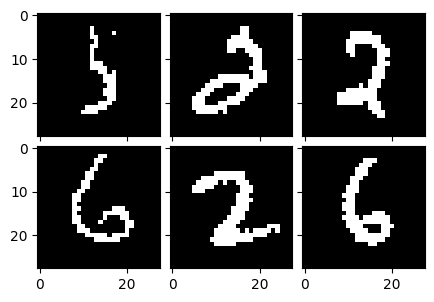

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
[INFO] Prédictions:
 digit: 5 	 -  digit: 5 	 -  digit: 5 	 - 
 digit: 5 	 -  digit: 1 	 -  digit: 5 	 - 



In [35]:
nb_imgs = 6
nb_rows = 2
nb_cols = 3

# load as b&w images
print("[INFO] Load demo images as Black'n White... ")
demo_imgs = [Image.open(os.path.join(DEMO_DIR, name)).convert('1') for name in os.listdir(DEMO_DIR)[:nb_imgs]]

fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(nb_rows, nb_cols),
    axes_pad=0.1,
)

for ax, img in zip(grid, demo_imgs):
    ax.imshow(img)
plt.show()

# Now let's predict

demo_imgs_arrays = np.array([
    np.asarray(demo_img).reshape(demo_img.size[0], demo_img.size[1], 1)
    for demo_img in demo_imgs
])
raw_predictions = model.predict(demo_imgs_arrays)

refined_predictions = []
for rp in raw_predictions:
    refined_predictions.append(np.argmax(rp))

print("[INFO] Prédictions:")

msg_pred = ""
cpt = 0
for i in range(nb_rows):
    for j in range(nb_cols):
        msg_pred += f" digit: {refined_predictions[cpt]} \t - "
        cpt += 1
    msg_pred += "\n"

print(msg_pred)

In [36]:
# Remind the hyperparameters values

t1 = time.time()

print("[INFO]")
print("[INFO] ======================= ")
print("[INFO] Hyperparameters")
print("[INFO] ======================= ")
print("[INFO]")
print(f"[INFO] batch_size = {batch_size}")
print(f"[INFO] epochs = {epochs}")

print("[INFO]")
print("[INFO] ======================= ")
print("[INFO] Train & Evaluate")
print("[INFO] ======================= ")
print("[INFO]")

# Fit the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    epochs=epochs
)

t2 = time.time()
print(f"[INFO] Duration = {t2-t1} seconds.")

# Note:
# During the fit, monitor the GPUs activity using: $ watch -n 0.5 nvidia-smi

[INFO]
[INFO] ======================= 
[INFO] Hyperparameters
[INFO] ======================= 
[INFO]
[INFO] batch_size = 64
[INFO] epochs = 10
[INFO]
[INFO] ======================= 
[INFO] Train & Evaluate
[INFO] ======================= 
[INFO]
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8289 - loss: 0.5567 - val_accuracy: 0.9798 - val_loss: 0.0681
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9717 - loss: 0.0957 - val_accuracy: 0.9831 - val_loss: 0.0508
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9786 - loss: 0.0705 - val_accuracy: 0.9868 - val_loss: 0.0387
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9818 - loss: 0.0582 - val_accuracy: 0.9877 - val_loss: 0.0365
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9845 - loss: 0.0527 - val_accuracy: 0.9883 - val_loss: 0.0326
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9861 - loss: 0.0456 - val_accuracy: 0.9882 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


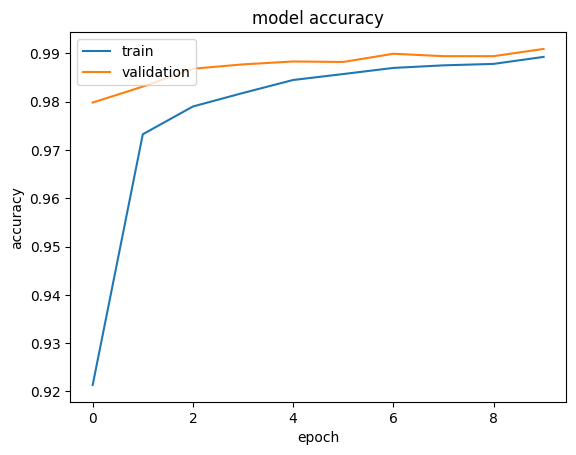

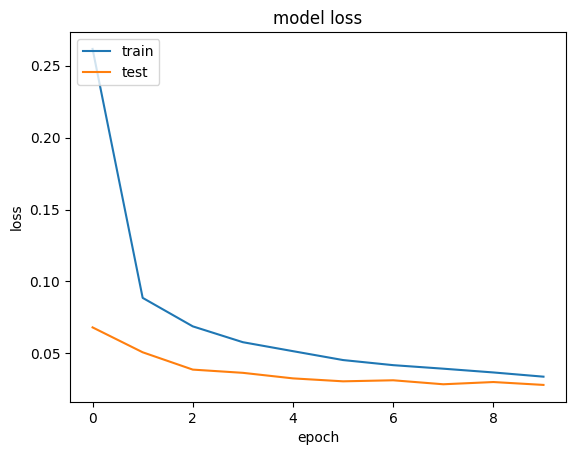

In [37]:
# check entries in the history
print(history.history.keys()) # => dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [38]:
# Final evaluation of the model
scores = model.evaluate(
    x=X_test,
    y=y_test,
    verbose=0
)

print("\n[INFO] Model Val Accuracy: %.2f%%, Error: %.2f%%" % (scores[1]*100, 100-scores[1]*100))


[INFO] Model Val Accuracy: 99.09%, Error: 0.91%


__Test some demo images afetr training__

[INFO] Previous demo images... 


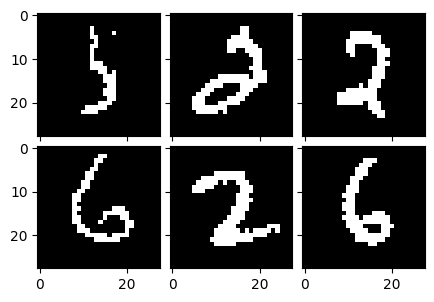

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[INFO] Prédictions:
 digit: 5 	 -  digit: 2 	 -  digit: 4 	 - 
 digit: 2 	 -  digit: 2 	 -  digit: 2 	 - 



In [39]:
# let's reuse the same previous demo settings...

print("[INFO] Previous demo images... ")
fig = plt.figure(figsize=(5., 5.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(nb_rows, nb_cols),
    axes_pad=0.1,
)

for ax, img in zip(grid, demo_imgs):
    ax.imshow(img)
plt.show()

# Now let's predict (again)
raw_predictions = model.predict(demo_imgs_arrays)

refined_predictions = []
for rp in raw_predictions:
    refined_predictions.append(np.argmax(rp))

print("[INFO] Prédictions:")

msg_pred = ""
cpt = 0
for i in range(nb_rows):
    for j in range(nb_cols):
        msg_pred += f" digit: {refined_predictions[cpt]} \t - "
        cpt += 1
    msg_pred += "\n"

print(msg_pred)

__END OF NOTEBOOK.__